In [1]:
from torchvision import transforms

import torchvision
import torch

from sklearn.metrics.pairwise import cosine_similarity
from copy import deepcopy
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import utils
import time
import cv2
import os

CONSUMER_PATH = '../videos/consumer/'
GUIDE_PATH = '../videos/guide/'

keypoint_names = {
    0: 'nose',
    1: 'left_eye',
    2: 'right_eye',
    3: 'left_ear', 
    4: 'right_ear', 
    5: 'left_shoulder', 
    6: 'right_shoulder',
    7: 'left_elbow', 
    8: 'right_elbow',
    9: 'left_wrist', 
    10: 'right_wrist',
    11: 'left_hip', 
    12: 'right_hip',
    13: 'left_knee', 
    14: 'right_knee',
    15: 'left_ankle', 
    16: 'right_ankle',
}

In [2]:
device = torch.device('cpu')
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True, num_keypoints=17, progress=False)
model.to(device).eval()

/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=KeypointRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load Datasets

### Consumer datasets

In [4]:
consumer_file_lists = os.listdir(CONSUMER_PATH)
consumer_file_lists = [os.path.join(CONSUMER_PATH, f) for f in consumer_file_lists]
print(f"Consumer file lists: {consumer_file_lists}")

Consumer file lists: ['../videos/consumer/consumer_1.mp4', '../videos/consumer/.DS_Store', '../videos/consumer/consumer_2.mp4', '../videos/consumer/consumer_3.mp4', '../videos/consumer/guide_1_1sec.mp4', '../videos/consumer/consumer_1_5sec.mp4']


In [5]:
consumer_video = cv2.VideoCapture('../videos/consumer/guide_1_1sec.mp4')
consumer_frame_width = int(consumer_video.get(3))
consumer_frame_height = int(consumer_video.get(4))

consumer_video_path = '../videos/consumer/guide_1_1sec.mp4'
# consumer_video_write = cv2.VideoWriter(
#     consumer_video_path,                # output file name
#     cv2.VideoWriter_fourcc(*'MP4V'),    # codec
#     20.0,                               # fps
#     (consumer_frame_width, consumer_frame_height) # frame size
# )

[mov,mp4,m4a,3gp,3g2,mj2 @ 0x179b36130] moov atom not found
OpenCV: Couldn't read video stream from file "../videos/consumer/guide_1_1sec.mp4"


### Guide datasets

In [12]:
guide_file_list = os.listdir(GUIDE_PATH)
guide_file_list = [os.path.join(GUIDE_PATH, file) for file in guide_file_list]
guide_file_list = [file for file in guide_file_list if file.endswith('.mp4')][0]

print(f"Guide file list: {guide_file_list}")

Guide file list: ../videos/guide/guide_1.mp4


In [13]:
guide_video = cv2.VideoCapture(guide_file_list)
guide_frame_width = int(guide_video.get(3))
guide_frame_height = int(guide_video.get(4))

guide_video_path = GUIDE_PATH + 'processed_videos_guide.mp4'
guide_video_write = cv2.VideoWriter(
    guide_video_path,                   # Path to the output video file
    cv2.VideoWriter_fourcc(*'mp4v'),    # Codec to be used
    20.0,                               # Frame rate of the video
    (guide_frame_width, guide_frame_height) # Frame size
)

# Guide Video Feature Extraction

In [21]:
total_fps, frame_count = 0, 0
guide_skeleton_list = []
pbar = tqdm(desc=f"Extracting skeleton from guide video", total=guide_video.get(cv2.CAP_PROP_FRAME_COUNT))
output_image = []

extracted_skeletons = {}

while True:
    ret, frame = guide_video.read()
    if ret == True:
        pbar.update(1)

        # Get frames from video, and convert to PIL image for processing with OpenPose
        original_image = deepcopy(frame)
        image_from_video = np.array(frame, dtype=np.float32) / 255.0

        # Transform the image to tensor
        image_from_video = torch.Tensor(image_from_video).permute(2, 0, 1)
        image_from_video = image_from_video.unsqueeze(0).to(device)

        # Get the output from the model
        start_time = time.time()
        with torch.no_grad():
            output = model(image_from_video)
        latency = time.time() - start_time

        # Get the keypoint from the output
        keypoints = utils.get_keypoints(output, None, threshold=0.9)
        guide_skeleton_list.append(keypoints)

        fps = 1 / latency 
        total_fps += fps
        frame_count += 1
        pbar.set_postfix({"FPS": fps, "Avg FPS": total_fps / frame_count})

        if frame_count == 1:    
            for i in range(len(keypoints)): extracted_skeletons[keypoint_names[i]] = []

        for i in range(len(keypoints)):
            x, y = keypoints[i][0], keypoints[i][1]
            extracted_skeletons[keypoint_names[i]].append((x, y))

        if frame_count > 5: break

        skeleton_image = utils.draw_keypoints(output, original_image)
        output_image.append(skeleton_image)

    else:
        break

pbar.close()

guide_skeleton_list = np.array(guide_skeleton_list)
guide_skeleton_list = guide_skeleton_list.astype(np.float32)
print(f"Guide skeleton list shape: {guide_skeleton_list.shape}")
print(extracted_skeletons)

Extracting skeleton from guide video:   0%|          | 1/546.0 [00:17<2:37:09, 17.30s/it, FPS=0.54, Avg FPS=0.54]
Extracting skeleton from guide video:   1%|          | 6/546.0 [00:10<15:54,  1.77s/it, FPS=0.588, Avg FPS=0.574]

Guide skeleton list shape: (6, 17, 3)
{'nose': [(529.78656, 479.08615), (528.3566, 478.06332), (530.2377, 475.20383), (529.2589, 475.96057), (526.3989, 478.88675), (528.38995, 479.16342)], 'left_eye': [(549.9232, 460.38028), (548.53613, 460.7808), (550.42426, 462.24472), (549.4002, 461.56427), (549.4422, 461.60724), (549.9691, 461.89853)], 'right_eye': [(508.21152, 460.38028), (506.73572, 460.7808), (508.60922, 460.8048), (504.8015, 461.56427), (504.79587, 461.60724), (505.37225, 461.89853)], 'left_ear': [(572.93665, 481.96396), (577.364, 480.94373), (573.49457, 483.84326), (573.85754, 483.1587), (573.92566, 483.2066), (572.9868, 483.47968)], 'right_ear': [(473.69144, 480.525), (473.58365, 479.5035), (472.56177, 482.40335), (471.71216, 481.7191), (473.1114, 483.2066), (472.2843, 482.04092)], 'left_shoulder': [(624.7167, 595.63794), (626.37134, 594.72015), (628.2867, 596.15564), (629.96564, 595.4498), (627.2132, 594.08356), (630.53107, 594.26294)], 'right_shoulder': [(416.15805, 594.199

Output image shape: (5, 1920, 1080, 3)


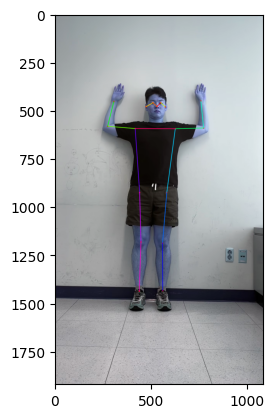

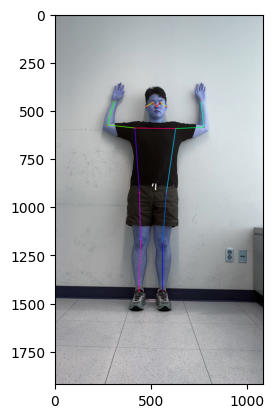

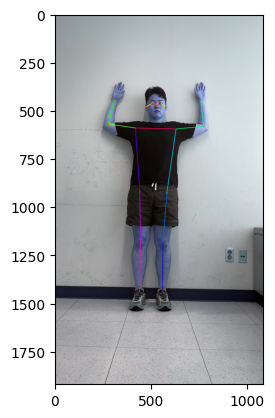

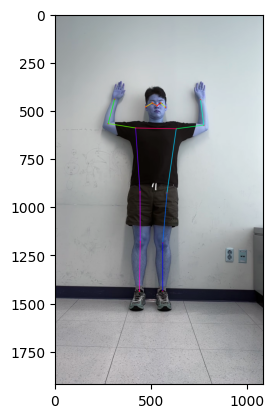

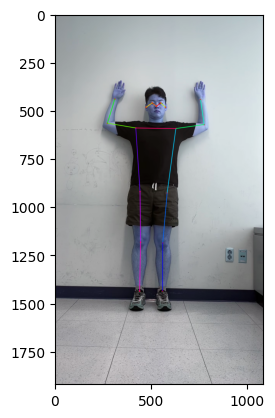

In [22]:
output_image = np.array(output_image, dtype=np.uint8)
print(f"Output image shape: {output_image.shape}")

for i in range(len(output_image)):    
    plt.imshow(output_image[i])
    plt.show()

In [14]:
total_fps, frame_count = 0, 0
consumer_skeleton_list = []
pbar = tqdm(desc=f"Extracting skeleton from consumer video", total=guide_video.get(cv2.CAP_PROP_FRAME_COUNT))

while True:
    ret, frame = consumer_video.read()
    if ret == True:
        pbar.update(1)

        # Get frames from video, and convert to PIL image for processing with OpenPose
        image_from_video = np.array(frame, dtype=np.float32) / 255.0
        original_image = deepcopy(image_from_video)

        # Transform the image to tensor
        image_from_video = torch.Tensor(image_from_video).permute(2, 0, 1)
        image_from_video = image_from_video.unsqueeze(0).to(device)

        # Get the output from the model
        start_time = time.time()
        with torch.no_grad():
            output = model(image_from_video)
        latency = time.time() - start_time

        # Get the keypoint from the output
        keypoints = utils.get_keypoints(output, original_image, threshold=0.9)
        consumer_skeleton_list.append(keypoints)

        fps = 1 / latency 
        total_fps += fps
        frame_count += 1
        pbar.set_postfix({"FPS": fps, "Avg FPS": total_fps / frame_count})

    else:
        break

pbar.close()

consumer_skeleton_list = np.array(consumer_skeleton_list)
consumer_skeleton_list = consumer_skeleton_list.astype(np.float32)
print(f"Consumer skeleton list shape: {consumer_skeleton_list.shape}")

Extracting skeleton from consumer video:   0%|          | 0/546.0 [00:00<?, ?it/s]

Consumer skeleton list shape: (0,)


# Get Similarty

In [10]:
y_true = guide_skeleton_list[:530].copy()
y_pred = consumer_skeleton_list[:530].copy()

y_ture, y_pred = np.array(y_true), np.array(y_pred)
y_true = y_true.reshape(-1, 1)
y_pred = y_pred.reshape(-1, 1)

similarities = cosine_similarity(y_true, y_pred)
print(similarities)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


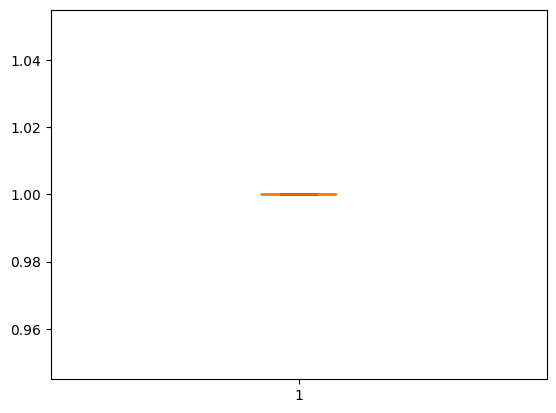

In [11]:
plt.boxplot(similarities.flatten())
plt.show()

In [12]:
similarities = similarities.flatten()
similarities = np.sum(similarities, axis=0) / len(similarities)

print(similarities)

1.0000000383235683


In [13]:
def mean_squared_error(x, y):
    return np.mean((x - y) ** 2)

def mean_absolute_error(x, y):
    return np.mean(np.abs(x - y))

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def manhattan_distance(x, y):
    return np.sum(np.abs(x - y))

def chebyshev_distance(x, y):
    return np.max(np.abs(x - y))

def minkowski_distance(x, y, p):
    return np.sum(np.abs(x - y) ** p) ** (1 / p)

def jaccard_similarity(x, y):
    return np.sum(np.min([x, y], axis=0)) / np.sum(np.max([x, y], axis=0))

def hamming_distance(x, y):
    return np.sum(x != y)

def kl_divergence(x, y):
    return np.sum(x * np.log(x / y))

def hellinger_distance(x, y):
    return np.sqrt(np.sum((np.sqrt(x) - np.sqrt(y)) ** 2)) / np.sqrt(2)

def bhattacharyya_distance(x, y):
    return -np.log(np.sum(np.sqrt(x * y)))

def pearson_correlation(x, y):
    return np.corrcoef(x, y)[0, 1]

def log_cosh(x, y):
    return np.log(np.cosh(x - y))

function_list = [
    mean_squared_error,
    mean_absolute_error,
    cosine_similarity,
    euclidean_distance,
    manhattan_distance,
    chebyshev_distance,
    minkowski_distance,
    jaccard_similarity,
    hamming_distance,
    kl_divergence,
    hellinger_distance,
    bhattacharyya_distance,
    pearson_correlation,
    log_cosh
]

In [14]:
print('-----------------------')
for fuc in function_list:
    try: 
        prediction = fuc(y_true, y_pred)
    except:
        continue

    print(fuc.__name__)
    print(prediction)
    print('-----------------------')

-----------------------
mean_squared_error
0.0
-----------------------
mean_absolute_error
0.0
-----------------------
euclidean_distance
0.0
-----------------------
manhattan_distance
0.0
-----------------------
chebyshev_distance
0.0
-----------------------
jaccard_similarity
1.0
-----------------------
hamming_distance
0
-----------------------
kl_divergence
0.0
-----------------------
hellinger_distance
0.0
-----------------------
bhattacharyya_distance
-16.244684
-----------------------


/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/bahk_insung/miniconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


pearson_correlation
nan
-----------------------
log_cosh
[[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
-----------------------
